In [4]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, NASNetMobile, ResNet50V2, EfficientNetB0, DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, MaxPool2D
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
TRAINING_DIR = "baru//Training"
VALIDATION_DIR = "baru//validation"

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255, ## Mengatur ulang skala piksel gambar dari [0, 255] menjadi [0, 1]
    fill_mode='nearest' ## Mengatur mode pengisian untuk gambar yang diproses, 'nearest' mengisi dengan nilai piksel terdekat
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical', ## Mengatur mode kelas menjadi 'categorical' untuk klasifikasi multi-kelas
                                                    target_size=(224, 224)) ## Mengubah ukuran semua gambar menjadi (224, 224) piksel

validation_datagen = ImageDataGenerator(
    rescale=1.0/255 ## Mengatur ulang skala piksel gambar dari [0, 255] menjadi [0, 1]
)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              class_mode='categorical', ## Mengatur mode kelas menjadi 'categorical' untuk klasifikasi multi-kelas
                                                              target_size=(224, 224)) ## Mengubah ukuran semua gambar menjadi (224, 224) piksel

Found 4254 images belonging to 5 classes.
Found 964 images belonging to 5 classes.


In [7]:
print(train_generator.class_indices)

{'BercakHitam': 0, 'BukanDaunAnggur': 1, 'DaunSehat': 2, 'HawarDaun': 3, 'KaratDaun': 4}


In [8]:
# Pretrain Model
pre_trained_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# Menggunakan model MobileNetV2 dengan ukuran input gambar 224x224 piksel dan 3 kanal warna (RGB)

for layer in pre_trained_model.layers:
    layer.trainable = False

In [9]:
model = tf.keras.Sequential([ 
    pre_trained_model, # Menambahkan model pra-terlatih MobileNetV2 sebagai lapisan pertama
    tf.keras.layers.GlobalAveragePooling2D(), # Menambahkan lapisan pooling global yang mengurangi dimensi fitur dari lapisan sebelumnya dengan menghitung rata-rata untuk setiap fitur
    tf.keras.layers.Dense(512, activation='relu'), # Menambahkan lapisan dense (fully connected) dengan 512 unit dan fungsi aktivasi ReLU
    tf.keras.layers.Dense(128, activation='relu'), # Menambahkan lapisan dense dengan 128 unit dan fungsi aktivasi ReLU
    tf.keras.layers.Dropout(0.3), # Menambahkan lapisan dropout dengan tingkat dropout 30% untuk mencegah overfitting
    tf.keras.layers.Dense(64, activation='relu'), # Menambahkan lapisan dense dengan 64 unit dan fungsi aktivasi ReLU
    tf.keras.layers.Dense(5, activation='softmax') # Menambahkan lapisan output dengan 5 unit dan fungsi aktivasi softmax untuk klasifikasi multi-kelas
])

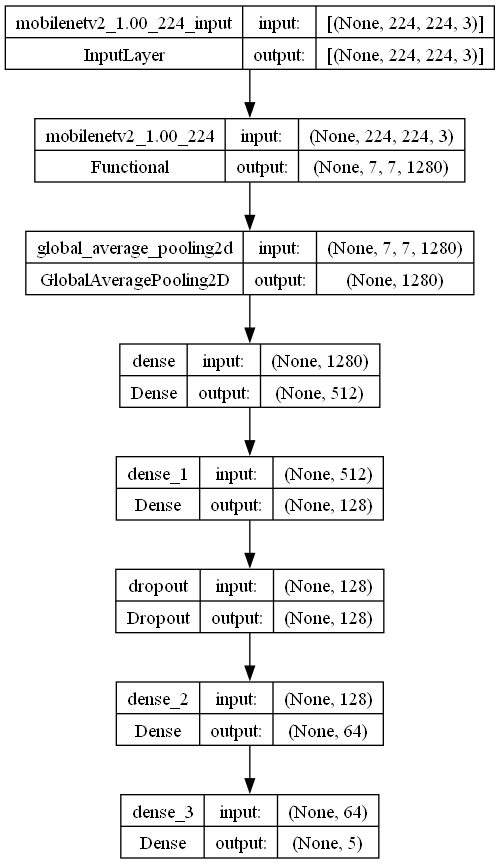

In [10]:
from tensorflow.keras.utils import plot_model

# visualisasi model
plot_model(model, to_file='model.png', show_shapes=True)

In [11]:
model.summary() ## Menampilkan ringkasan arsitektur model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8

In [12]:
int_lr = 0.0001 ## Mengatur laju pembelajaran awal menjadi 0.0001
num_epochs = 100 ## Mengatur jumlah epoch pelatihan menjadi 100

# Early Stopping
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', ## Memantau akurasi validasi untuk menentukan kapan harus menghentikan pelatihan
    patience=5, ## Menghentikan pelatihan jika akurasi validasi tidak membaik setelah 5 epoch
    restore_best_weights=True, ## Mengembalikan bobot model ke kondisi terbaik saat pelatihan dihentikan
    verbose=1 ## Menampilkan pesan ketika pelatihan dihentikan lebih awal
)

# Model Checkpoint
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_weights.h5', ## Menyimpan bobot model terbaik ke file 'best_weights.h5'
    monitor='val_accuracy', ## Memantau akurasi validasi untuk menentukan kapan menyimpan bobot model
    save_best_only=True, ## Hanya menyimpan bobot model jika akurasi validasi meningkat
    save_weights_only=True, ## Hanya menyimpan bobot model, bukan keseluruhan model
    verbose=1 ## Menampilkan pesan ketika bobot model disimpan
)

# Compile and Training
optimizer = tf.optimizers.Adam(learning_rate=int_lr) ## Menggunakan optimizer Adam dengan laju pembelajaran yang telah ditentukan
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy', ## Menggunakan fungsi loss categorical crossentropy untuk klasifikasi multi-kelas
              metrics=['accuracy']) ## Memantau akurasi selama pelatihan

model.fit(
    train_generator, ## Data generator untuk pelatihan
    epochs=num_epochs, ## Jumlah epoch pelatihan
    validation_data=validation_generator, ## Data generator untuk validasi
    callbacks=[earlystop_callback, checkpoint_callback] ## Menggunakan callback untuk early stopping dan checkpoint model
)

Epoch 1/100
133/133 [==============================] - ETA: 0s - loss: 0.8156 - accuracy: 0.6815
Epoch 1: val_accuracy improved from -inf to 0.85062, saving model to best_weights.h5
133/133 [==============================] - 224s 2s/step - loss: 0.8156 - accuracy: 0.6815 - val_loss: 0.4588 - val_accuracy: 0.8506
Epoch 2/100
133/133 [==============================] - ETA: 0s - loss: 0.4456 - accuracy: 0.8265
Epoch 2: val_accuracy did not improve from 0.85062
133/133 [==============================] - 239s 2s/step - loss: 0.4456 - accuracy: 0.8265 - val_loss: 0.3722 - val_accuracy: 0.8454
Epoch 3/100
133/133 [==============================] - ETA: 0s - loss: 0.3552 - accuracy: 0.8611
Epoch 3: val_accuracy improved from 0.85062 to 0.88485, saving model to best_weights.h5
133/133 [==============================] - 205s 2s/step - loss: 0.3552 - accuracy: 0.8611 - val_loss: 0.2981 - val_accuracy: 0.8849
Epoch 4/100
133/133 [==============================] - ETA: 0s - loss: 0.2888 - accuracy:

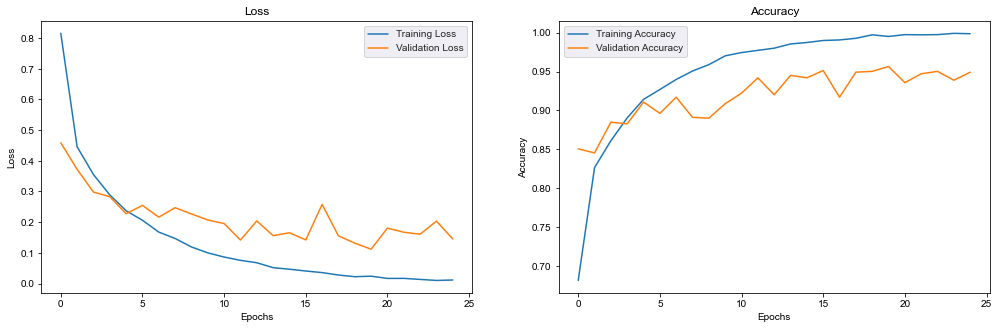

In [13]:
# Membuat list nilai loss dan akurasi dari model
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
train_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

# Membuat plot
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
sns.set_style("darkgrid")

# Plot loss
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss')
ax[0].legend()

# Plot accuracy
ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

In [14]:
# Load weights
model.load_weights('best_weights.h5') ## Memuat bobot model terbaik yang disimpan di file 'best_weights.h5'

# Evaluate model on validation set
loss, accuracy = model.evaluate(validation_generator, verbose=1) ## Mengevaluasi kinerja model pada set data validasi dan menampilkan proses evaluasi

print('Validation Accuracy: {:.2%}'.format(accuracy)) ## Mencetak akurasi validasi dengan format persentase
print('Validation Loss: {:.2f}'.format(loss)) ## Mencetak loss validasi dengan format desimal dua tempat

31/31 [==============================] - 20s 643ms/step - loss: 0.1120 - accuracy: 0.9564
Validation Accuracy: 95.64%
Validation Loss: 0.11


In [15]:
# Mendapatkan label yang sesuai dengan prediksi
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}

In [16]:
# Memuat bobot terbaik yang disimpan selama pelatihan
model.load_weights('best_weights.h5')

# Mengumpulkan semua prediksi dan label asli
y_pred = []
labels = []
for i in range(len(validation_generator)):
    batch_data, batch_labels = validation_generator[i]
    batch_pred = model.predict(batch_data)
    y_pred.extend(np.argmax(batch_pred, axis=1))
    labels.extend(np.argmax(batch_labels, axis=1))

1/1 [==============================] - 1s 820ms/step


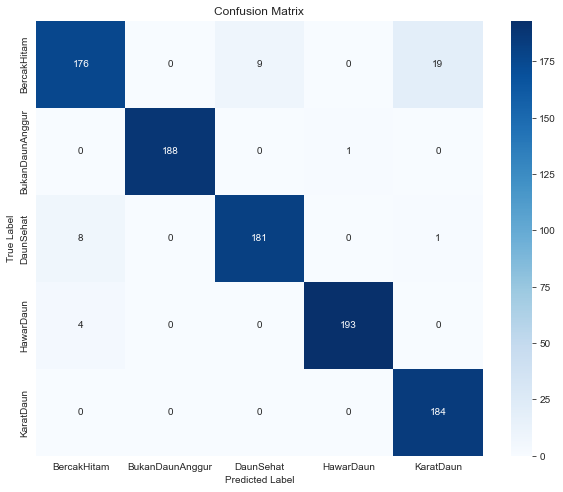

Classification Report:
                 precision    recall  f1-score   support

    BercakHitam       0.94      0.86      0.90       204
BukanDaunAnggur       1.00      0.99      1.00       189
      DaunSehat       0.95      0.95      0.95       190
      HawarDaun       0.99      0.98      0.99       197
      KaratDaun       0.90      1.00      0.95       184

       accuracy                           0.96       964
      macro avg       0.96      0.96      0.96       964
   weighted avg       0.96      0.96      0.96       964



In [17]:
# Menghitung matriks kebingungan
cm = confusion_matrix(labels, y_pred)

# Menghitung akurasi
accuracy = np.sum(labels == y_pred) / len(labels)

# Membuat plot matriks kebingungan
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Mencetak laporan klasifikasi
classification_report_str = classification_report(labels, y_pred, target_names=class_labels.values())
print("Classification Report:")
print(classification_report_str)

In [18]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi .tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('mobilenetv2.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


11790620